In [4]:
sudo apt install libportaudio2 libportaudiocpp0 portaudio19-dev

SyntaxError: invalid syntax (2479830207.py, line 1)

In [ ]:
import sounddevice as sd
mic_list = sd.query_devices()
print(mic_list)

print('audio name은 (Microphone(High Definition Audio Device), Windows DirectSound (2 in, 0 out)입니다') #윈도우에서
print('audio name은  default, ALSA (32 in, 32 out)') # 리눅스에서

 # 원래 시작 단위로 처음 시작을 절대 잊어버리지 않는거

   0 sof-hda-dsp: - (hw:0,0), ALSA (2 in, 0 out)
   1 sof-hda-dsp: - (hw:0,3), ALSA (0 in, 2 out)
   2 sof-hda-dsp: - (hw:0,4), ALSA (0 in, 2 out)
   3 sof-hda-dsp: - (hw:0,5), ALSA (0 in, 2 out)
   4 sof-hda-dsp: - (hw:0,7), ALSA (2 in, 0 out)
   5 sysdefault, ALSA (128 in, 0 out)
   6 samplerate, ALSA (128 in, 0 out)
   7 speexrate, ALSA (128 in, 0 out)
   8 pulse, ALSA (32 in, 32 out)
   9 upmix, ALSA (8 in, 0 out)
  10 vdownmix, ALSA (6 in, 0 out)
* 11 default, ALSA (32 in, 32 out)
audio name은 (Microphone(High Definition Audio Device), Windows DirectSound (2 in, 0 out)입니다


In [14]:
import pyaudio

p = pyaudio.PyAudio()
for i in range(p.get_device_count()):
    dev = p.get_device_info_by_index(i)
    if dev['maxInputChannels'] > 0:  # 마이크 장치만 출력
        print(f"Index: {i}, Name: {dev['name']}")

Index: 0, Name: sof-hda-dsp: - (hw:0,0)
Index: 4, Name: sof-hda-dsp: - (hw:0,7)
Index: 5, Name: sysdefault
Index: 6, Name: samplerate
Index: 7, Name: speexrate
Index: 8, Name: pulse
Index: 9, Name: upmix
Index: 10, Name: vdownmix
Index: 11, Name: default


In [21]:
pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 680.8 kB/s  0:00:12 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 835.9 kB/s  0:00:05m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.5 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


In [29]:
import sounddevice as sd
import soundfile as sf
import time
import json

DEVICE = 11   # 후보 장치 번호
SR = 16000
DUR = 5

# 세션 시작 시점 기록
t0 = time.time()

print(f"Recording {DUR}s from device {DEVICE} ...")
audio = sd.rec(int(DUR*SR), samplerate=SR, channels=1, dtype='int16', device=DEVICE)
sd.wait()

# 저장 (원본 wav)
sf.write("test.wav", audio, SR)
print("Saved test.wav")

# 각 샘플의 절대 시간 계산 (원하면 프레임 단위로 downsample 가능)
timestamps = [t0 + i/SR for i in range(len(audio))]

# 메타데이터 저장
meta = {
    "device": DEVICE,
    "sr": SR,
    "duration": DUR,
    "start_time": t0,             # Unix epoch (초)
    "timestamps[0]": timestamps[0],
    "timestamps[-1]": timestamps[-1],
    "total_samples": len(audio)
}

with open("test_meta.json", "w") as f:
    json.dump(meta, f, indent=2)

print("Saved test_meta.json")


Recording 5s from device 11 ...
Saved test.wav
Saved test_meta.json


Mel shape: (64, 501)


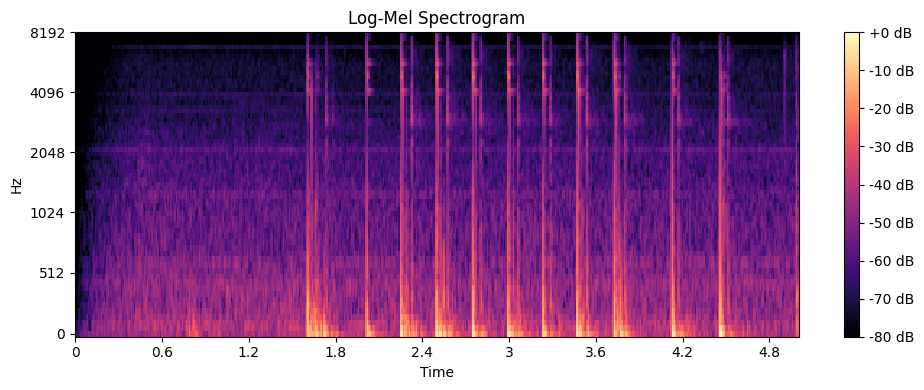

In [30]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# 1) 오디오 불러오기
y, sr = librosa.load("test.wav", sr=16000)  # sr=16kHz로 리샘플링

# 2) 멜 스펙트로그램 계산
n_fft = 1024         # FFT 윈도우 크기 (보통 20~40ms → 1024 @16kHz)
hop_length = 160     # 홉 크기 (10ms → 160 @16kHz)
win_length = 400     # 윈도우 길이 (25ms → 400 @16kHz)
n_mels = 64          # 멜 필터 개수 (64~128 자주 사용)
fmin, fmax = 50, 8000  # 주파수 대역

S = librosa.feature.melspectrogram(
    y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
    win_length=win_length, n_mels=n_mels, fmin=fmin, fmax=fmax, power=2.0
)

# 3) 로그 스케일(dB) 변환
S_dB = librosa.power_to_db(S, ref=np.max)

# 4) 저장 및 시각화
np.save("mel.npy", S_dB)  # 학습용 데이터 저장
print("Mel shape:", S_dB.shape)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, hop_length=hop_length,
                         x_axis="time", y_axis="mel", fmax=fmax)
plt.colorbar(format="%+2.0f dB")
plt.title("Log-Mel Spectrogram")
plt.tight_layout()
plt.savefig("mel.png", dpi=200)
plt.show()


In [3]:
S_dB

array([[-32.069706, -31.694025, -34.03051 , ..., -35.653347, -36.099545,
        -36.106224],
       [-37.44423 , -34.65676 , -38.48222 , ..., -41.203743, -38.182922,
        -45.534027],
       [-50.001038, -40.709698, -46.80829 , ..., -50.608864, -46.293827,
        -56.002106],
       ...,
       [-74.06828 , -75.2785  , -74.993126, ..., -75.75848 , -74.57138 ,
        -75.86047 ],
       [-75.15953 , -76.05541 , -72.28919 , ..., -74.40263 , -75.46035 ,
        -76.223946],
       [-79.23908 , -78.17672 , -76.94758 , ..., -77.20235 , -77.68124 ,
        -78.450294]], dtype=float32)